In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
from collections import defaultdict

In [2]:
def load_jsonl(file_path: str) -> List[Dict]:
    """Load data from a jsonl file."""
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [12]:
# Function to extract numerical part for sorting model names
def sort_key_model(model_name: str) -> float:
    """Extracts a numerical value from model names for sorting (e.g., 'Qwen3-0.6B' -> 0.6)."""
    if "Qwen3-" in model_name:
        try:
            # Handle 'B' and convert to float (e.g., '0.6B' -> 0.6, '1.8B' -> 1.8, '14B' -> 14.0)
            num_part = model_name.split("Qwen3-")[1].replace("B", "")
            return float(num_part)
        except ValueError:
            return float("inf")  # Put non-standard names at the end
    return float("inf")  # Put models without "Qwen3-" at the end

In [3]:
def get_average_scores(data: List[Dict]) -> Tuple[float, float]:
    """Calculate average COMET and COMET-KIWI scores from data."""
    comet_scores = [
        item.get("comet_score", 0) for item in data if "comet_score" in item
    ]
    kiwi_scores = [
        item.get("comet_kiwi_score", 0) for item in data if "comet_kiwi_score" in item
    ]

    avg_comet = np.mean(comet_scores) if comet_scores else 0
    avg_kiwi = np.mean(kiwi_scores) if kiwi_scores else 0

    return avg_comet, avg_kiwi

In [4]:
# Base directory
base_dir = "/scratch/project_2008161/members/zihao/rm4mt/rm4mt_translated_with_comet"

# Dictionary to store results: task -> model -> budget -> (avg_comet, avg_kiwi)
results = defaultdict(lambda: defaultdict(dict))

In [25]:
# Scan directory structure
for task in os.listdir(base_dir):
    task_dir = os.path.join(base_dir, task)
    if not os.path.isdir(task_dir):
        continue

    for model in os.listdir(task_dir):
        model_dir = os.path.join(task_dir, model)
        if not os.path.isdir(model_dir):
            continue

        for budget_folder in os.listdir(model_dir):
            budget_dir = os.path.join(model_dir, budget_folder)
            if not os.path.isdir(budget_dir):
                continue

            # Extract budget as integer
            try:
                if budget_folder.startswith("budget_"):
                    budget = int(budget_folder.split("_")[1])
                else:
                    budget = int(budget_folder)
            except ValueError:
                print(f"Skipping non-budget folder: {budget_folder}")
                continue

            # Look for jsonl files and merge all
            all_data = []
            for file in os.listdir(budget_dir):
                if file.endswith(".jsonl"):
                    file_path = os.path.join(budget_dir, file)
                    try:
                        data = load_jsonl(file_path)
                        all_data.extend(data)
                        # avg_comet, avg_kiwi = get_average_scores(data)
                        # results[task][model][budget] = (avg_comet, avg_kiwi)
                        # We're assuming there's only one relevant jsonl file per budget folder
                        break
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

            if all_data:
                avg_comet, avg_kiwi = get_average_scores(all_data)
                # avg_tokens = get_average_tokens(all_data, key="reasoning")
                results[task][model][budget] = (avg_comet, avg_kiwi)

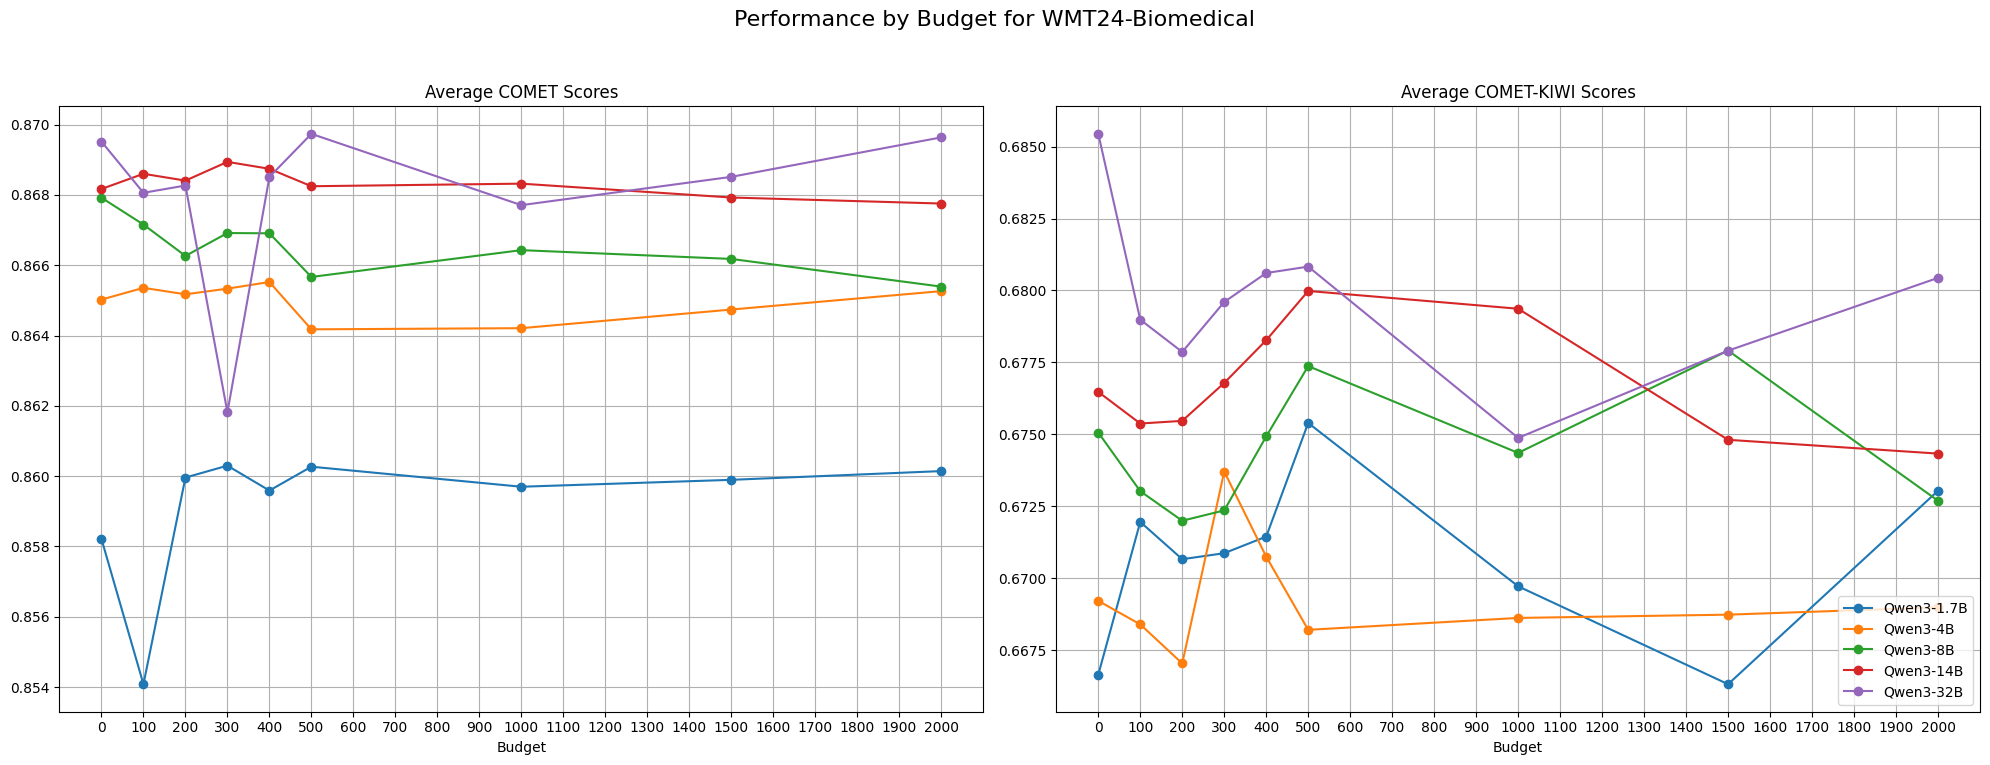

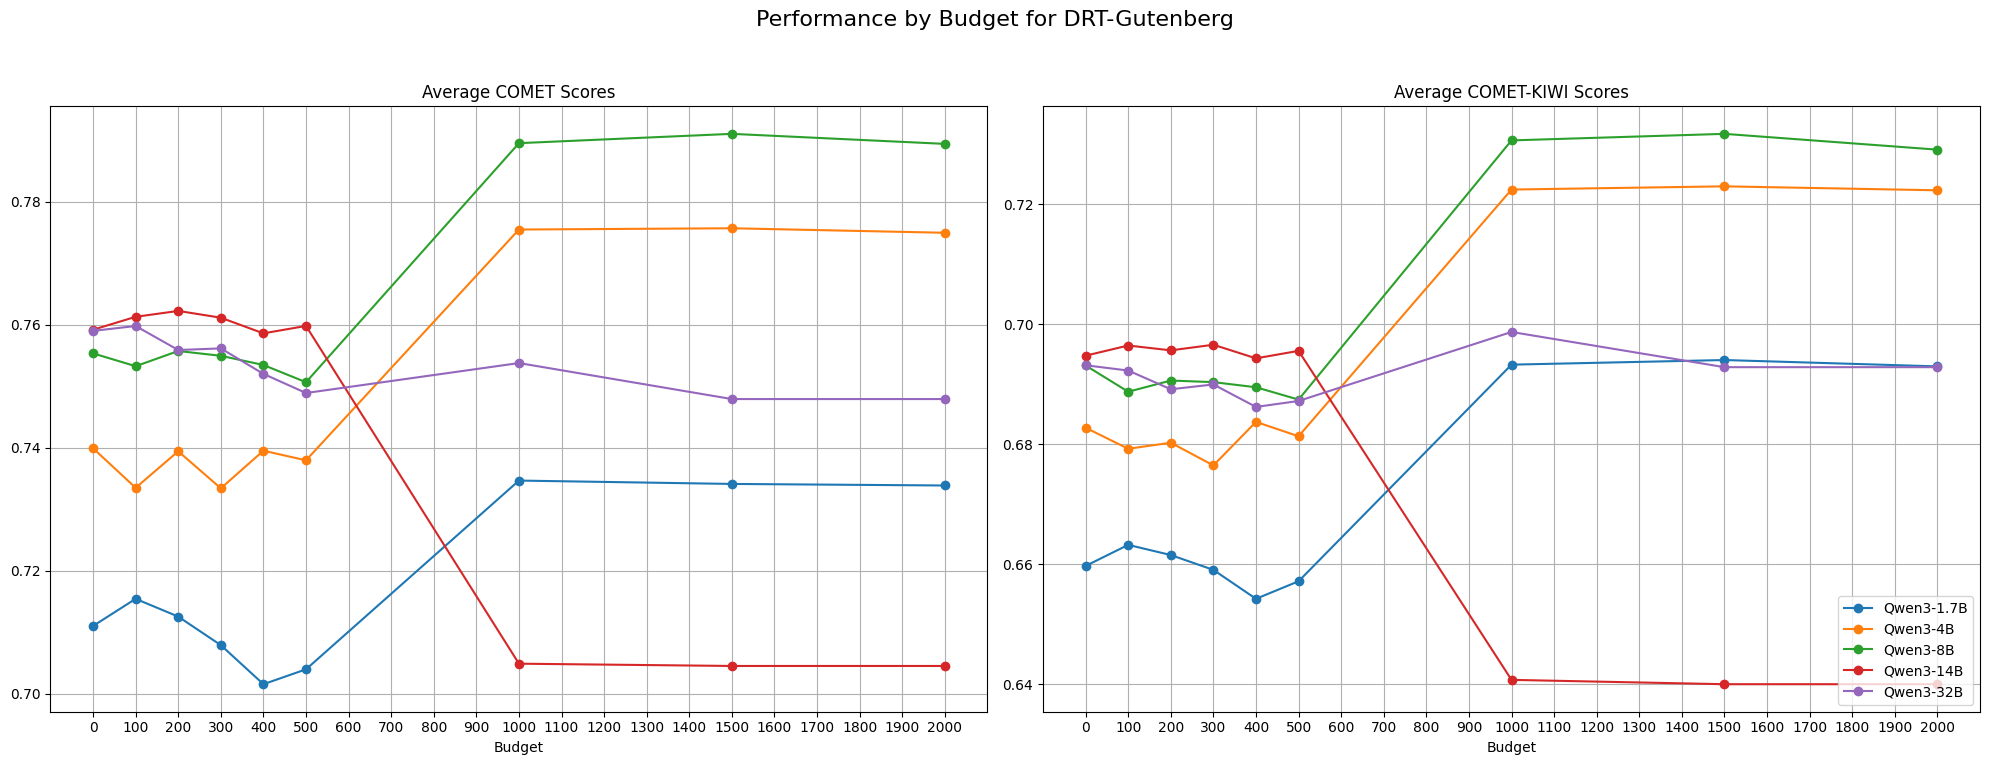

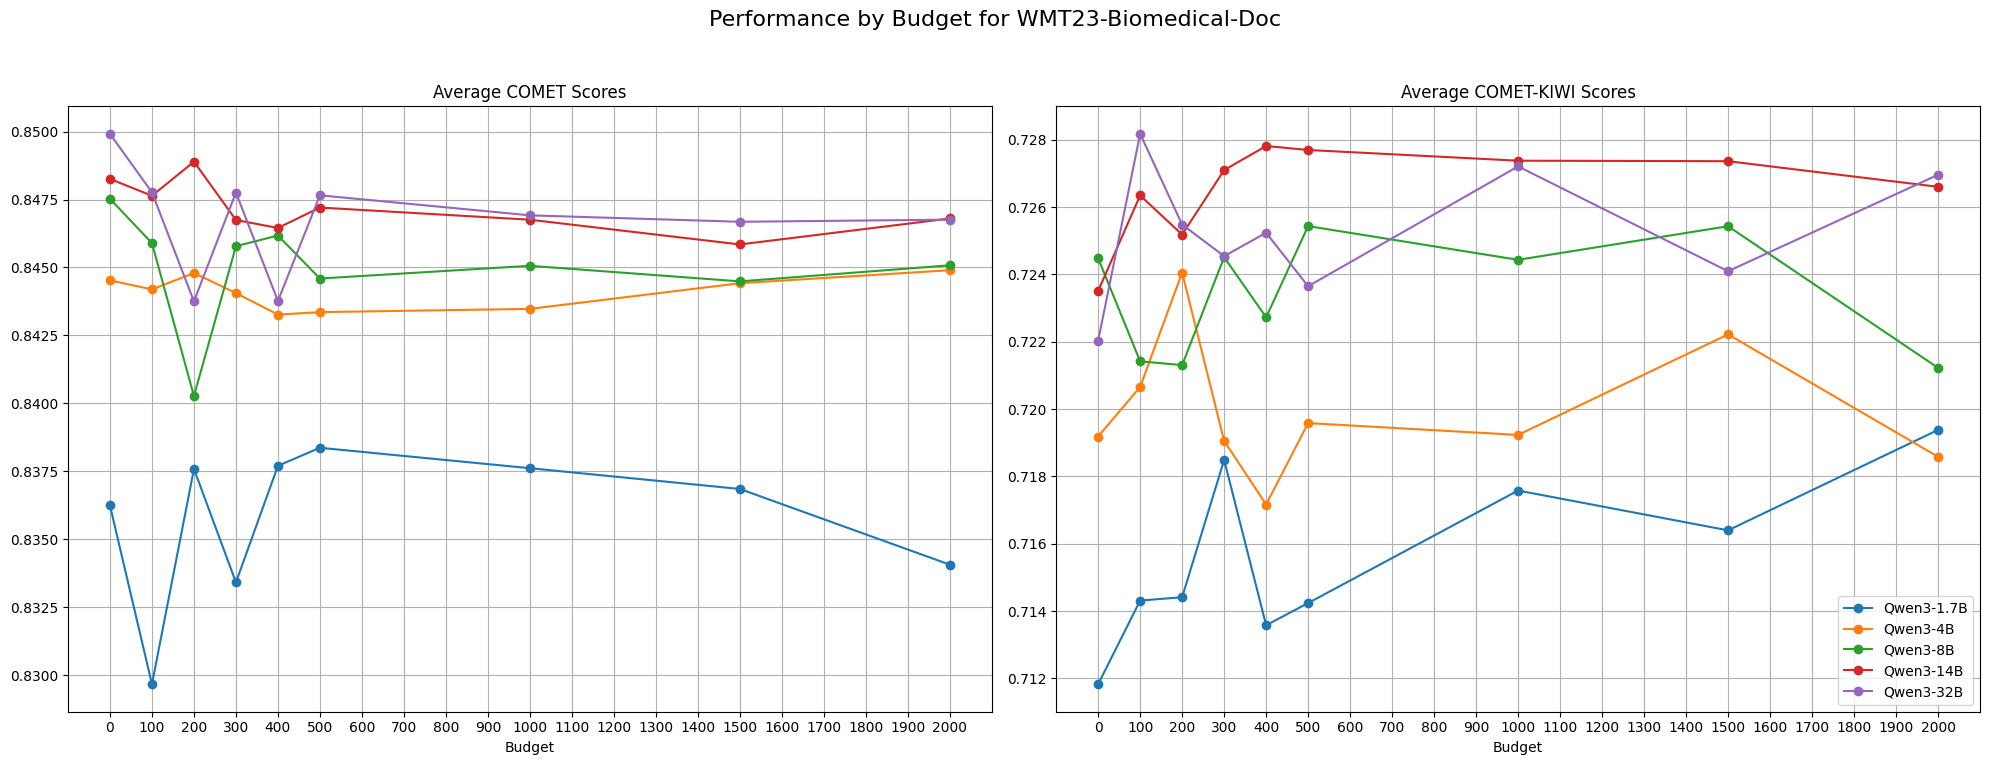

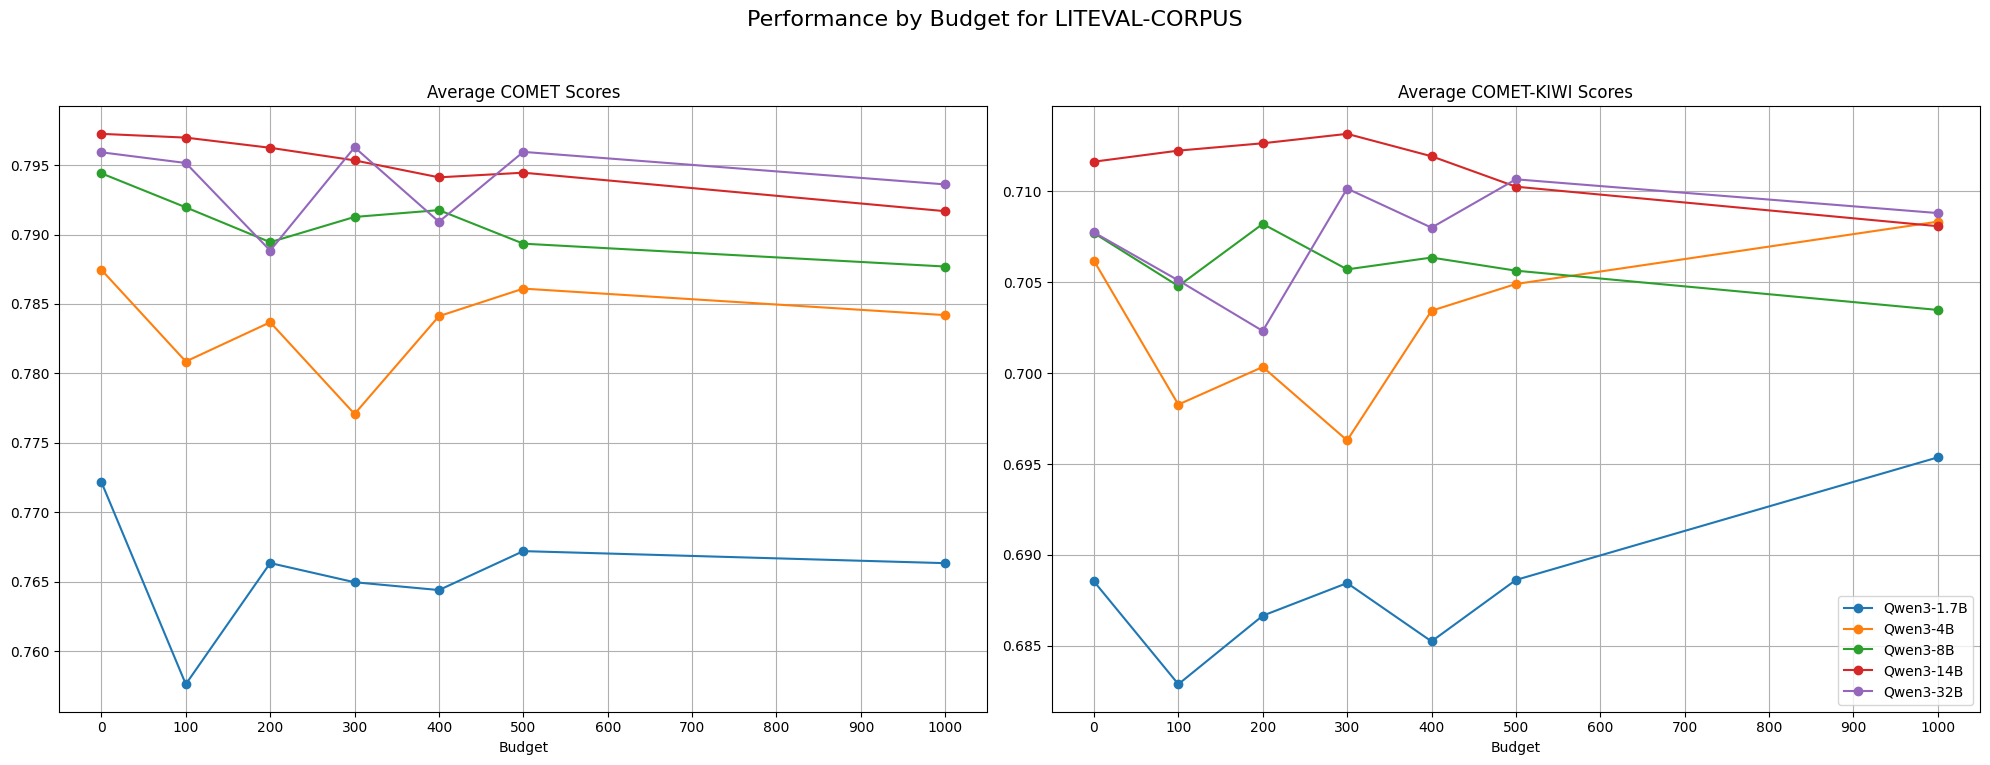

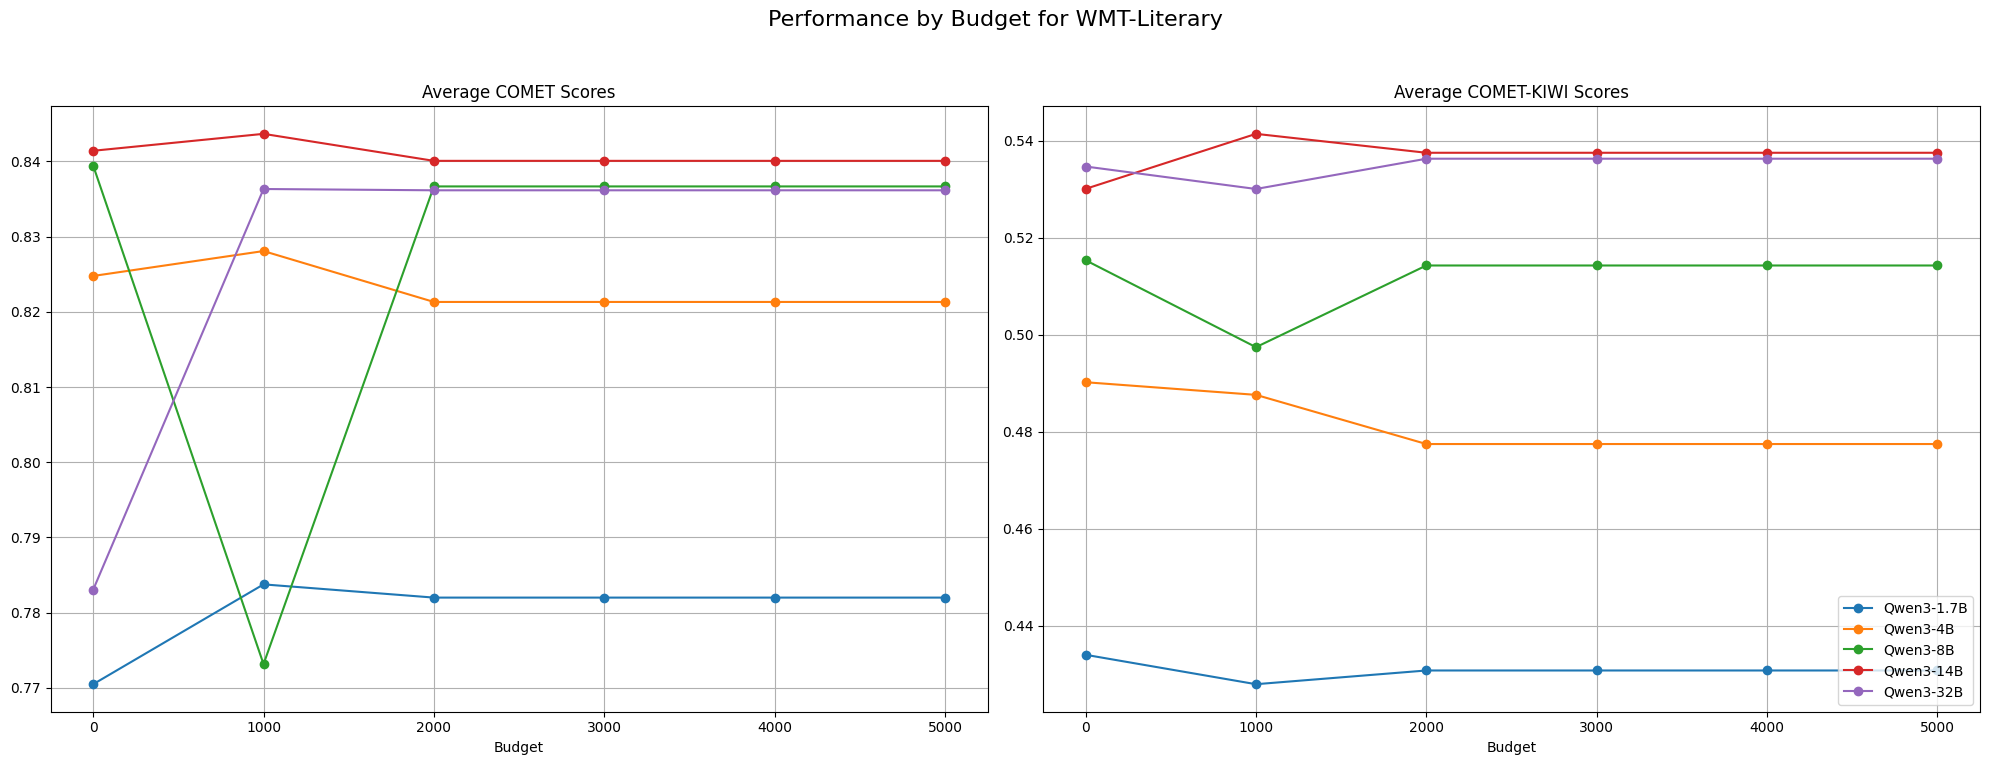

In [26]:
# Create plots for each task
for task, models in results.items():
    if "Qwen3-0.6B" in models:
        del models["Qwen3-0.6B"]
    if "gemini-2.5-flash-preview-05-20" in models:
        del models["gemini-2.5-flash-preview-05-20"]

    if task == "WMT-Literary":
        step_size = 1000
    else:
        step_size = 100

    # Sort models by their numerical part (e.g., Qwen3-0.6B, Qwen3-1.8B, Qwen3-14B)
    sorted_models = sorted(models.items(), key=lambda item: sort_key_model(item[0]))

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Increased figure size for two plots

    # Determine min and max budget for x-axis ticks
    min_budget = min(
        min(budgets.keys()) for model, budgets in models.items() if budgets
    )
    max_budget = max(
        max(budgets.keys()) for model, budgets in models.items() if budgets
    )
    xticks = range(min_budget - min_budget % step_size, max_budget + step_size, step_size)

    # Plot for COMET scores on the first subplot (axes[0])
    for model, budgets in sorted_models:
        x = sorted(budgets.keys())
        y = [budgets[budget][0] for budget in x]  # COMET scores
        axes[0].plot(x, y, marker="o", label=model)

    axes[0].set_xlabel("Budget")
    # axes[0].set_ylabel("Average COMET Score")
    axes[0].set_title("Average COMET Scores")
    axes[0].set_xticks(xticks)
    # axes[0].legend()
    axes[0].grid(True)

    # Plot for COMET-KIWI scores on the second subplot (axes[1])
    for model, budgets in sorted_models:
        x = sorted(budgets.keys())
        y = [budgets[budget][1] for budget in x]  # COMET-KIWI scores
        axes[1].plot(x, y, marker="o", label=model)

    axes[1].set_xlabel("Budget")
    # axes[1].set_ylabel("Average COMET-KIWI Score")
    axes[1].set_title("Average COMET-KIWI Scores")
    axes[1].set_xticks(xticks)
    axes[1].legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
    axes[1].grid(True)

    # Add a main title for the entire figure
    fig.suptitle(f"Performance by Budget for {task}", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()